### Import libraries

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as w
import statsmodels.api as stats
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

pd.set_option("display.max_rows", None,"display.max_columns", None)
w.simplefilter(action='ignore')
plt.style.use('seaborn')


## Read Dataset

In [100]:
# declare & preview df
df = pd.read_csv("data.csv")
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [101]:
# set all column names to lower case
df.columns = df.columns.str.lower()

In [102]:
# nr of rows / columns
df.shape

(96453, 12)

In [103]:
# data types
df.dtypes

formatted date               object
summary                      object
precip type                  object
temperature (c)             float64
apparent temperature (c)    float64
humidity                    float64
wind speed (km/h)           float64
wind bearing (degrees)      float64
visibility (km)             float64
loud cover                  float64
pressure (millibars)        float64
daily summary                object
dtype: object

 - Declare categoricals & numericals feature variables

In [104]:
categorical_features = df.select_dtypes(include=["object"]).keys()
print(categorical_features)

Index(['formatted date', 'summary', 'precip type', 'daily summary'], dtype='object')


In [105]:
numerical_features = df.select_dtypes(include=["int64","float64"]).keys()
print(numerical_features)

Index(['temperature (c)', 'apparent temperature (c)', 'humidity',
       'wind speed (km/h)', 'wind bearing (degrees)', 'visibility (km)',
       'loud cover', 'pressure (millibars)'],
      dtype='object')


In [106]:
# check null values for columns
df.isnull().sum()

formatted date                0
summary                       0
precip type                 517
temperature (c)               0
apparent temperature (c)      0
humidity                      0
wind speed (km/h)             0
wind bearing (degrees)        0
visibility (km)               0
loud cover                    0
pressure (millibars)          0
daily summary                 0
dtype: int64

In [107]:
total_rows = df["formatted date"].count()
total_na_precip_type = df["precip type"].isnull().sum()

print(f"Total % of NaN values for Precip Type: {100 * round(total_na_precip_type / total_rows, 4)}%")


Total % of NaN values for Precip Type: 0.54%


In [108]:
# check precip type
df["precip type"].value_counts()

rain    85224
snow    10712
Name: precip type, dtype: int64

<AxesSubplot:xlabel='precip type', ylabel='count'>

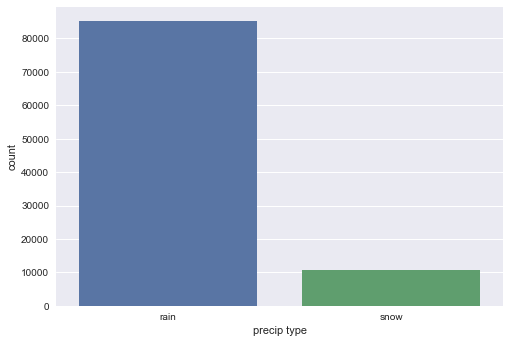

In [109]:
sns.countplot(data=df,x='precip type')

In [110]:
# summary for numerical features
df.describe()

,temperature (c),apparent temperature (c),humidity,wind speed (km/h),wind bearing (degrees),visibility (km),loud cover,pressure (millibars)
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.0,96453.000000
mean,11.932678,10.855029,0.734899,10.810640,187.509232,10.347325,0.0,1003.235956
std,9.551546,10.696847,0.195473,6.913571,107.383428,4.192123,0.0,116.969906
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,0.0,1011.900000
50%,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,0.0,1016.450000
75%,18.838889,18.838889,0.890000,14.135800,290.000000,14.812000,0.0,1021.090000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,0.0,1046.380000


## Exploratory Data Analysis

 - Histograms for quantity distribution (numerical features)

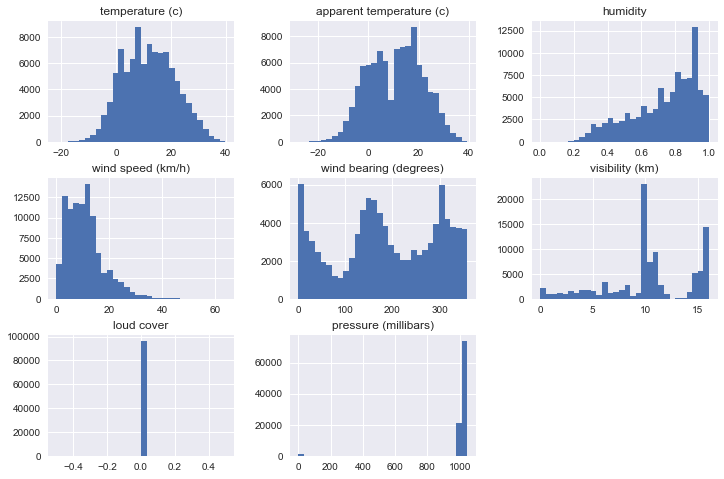

In [111]:
df.hist(bins=30,figsize=(12,8))
plt.show()

Overall Distribution notes:
 - *temperature* & *apparent temperature* have a **normal distribution** (they follow a type of bell-shape\)
 - *humidity* has a **left-skewed distribution** (long tail extends to the left while most values cluster on the right)
 - *wind speed* has a **right-skewed distribution**
 - *wind bearing* & *visibility* have a **multimodal distribution** (has more than one peak)
 - *loud cover* has all 0-values (we can drop this feature)

In [112]:
df = df.drop("loud cover", axis=1)

 - pressure has some values at 0 - they're probably missing values as there's no pressure = 0 in real-life
 - we can replace these with the pressure median

<AxesSubplot:>

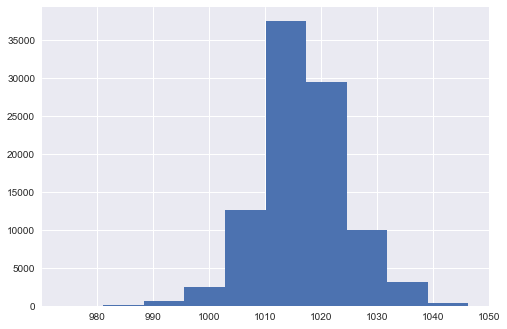

In [113]:
pressure_median = df["pressure (millibars)"].median()

def replace_pressure_zeros(row):
    if row == 0:
        return row + pressure_median
    else:
        return row

df["pressure (millibars)"] = df.apply(lambda x: replace_pressure_zeros(x["pressure (millibars)"]), axis=1)
df["pressure (millibars)"].hist()

 - Check humidity distribution by *Summary*

array([[<AxesSubplot:title={'center':'Breezy'}>,
        <AxesSubplot:title={'center':'Breezy and Dry'}>,
        <AxesSubplot:title={'center':'Breezy and Foggy'}>,
        <AxesSubplot:title={'center':'Breezy and Mostly Cloudy'}>,
        <AxesSubplot:title={'center':'Breezy and Overcast'}>],
       [<AxesSubplot:title={'center':'Breezy and Partly Cloudy'}>,
        <AxesSubplot:title={'center':'Clear'}>,
        <AxesSubplot:title={'center':'Dangerously Windy and Partly Cloudy'}>,
        <AxesSubplot:title={'center':'Drizzle'}>,
        <AxesSubplot:title={'center':'Dry'}>],
       [<AxesSubplot:title={'center':'Dry and Mostly Cloudy'}>,
        <AxesSubplot:title={'center':'Dry and Partly Cloudy'}>,
        <AxesSubplot:title={'center':'Foggy'}>,
        <AxesSubplot:title={'center':'Humid and Mostly Cloudy'}>,
        <AxesSubplot:title={'center':'Humid and Overcast'}>],
       [<AxesSubplot:title={'center':'Humid and Partly Cloudy'}>,
        <AxesSubplot:title={'center':'Light R

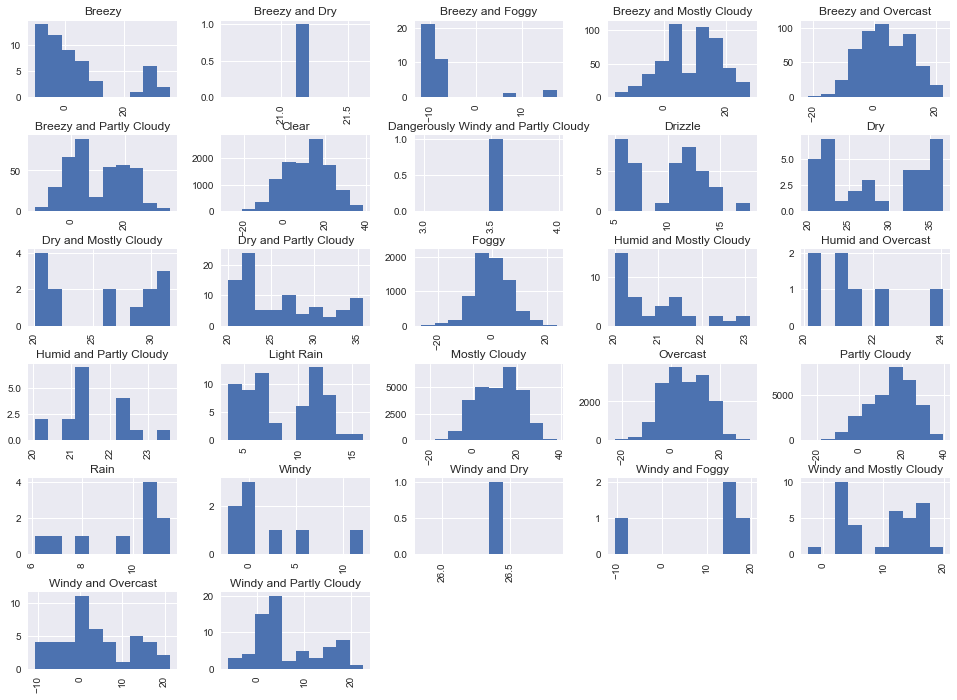

In [114]:
df["apparent temperature (c)"].hist(by=df["summary"], figsize=(16,12))

 - This also tell us that there are many unique Summary types, we could group these to have better representation of the data

## Feature Engineering

- check all unique values in Summary

In [115]:

len(df["summary"].unique())

27

 - check value count in Sumary

<AxesSubplot:xlabel='count', ylabel='summary'>

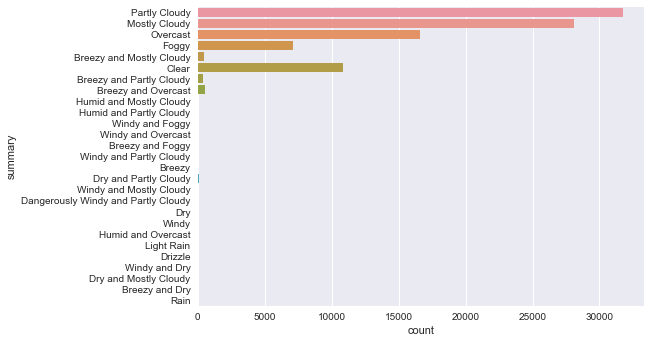

In [116]:
sns.countplot(y=df["summary"])

 - We can see that are are in total 27 but only a few appear to have the highest frequency
 - Let's check realtive frequency to determine how to group these


In [117]:
df_req_summary = pd.crosstab(index=df["summary"], columns="count")
df_relative_freq_summary = df_req_summary / df_req_summary.sum()
df_relative_freq_summary
df_relative_freq_summary.sort_values(by="count", ascending=False)


col_0,count
summary,
Partly Cloudy,0.329000
Mostly Cloudy,0.291271
Overcast,0.172073
Clear,0.112905
Foggy,0.074109
Breezy and Overcast,0.005474
Breezy and Mostly Cloudy,0.005350
Breezy and Partly Cloudy,0.004002
Dry and Partly Cloudy,0.000892


 - partly cloudy (33%); mostly cloudy (29%); overcast (17%); clear (11%); foggy (7%) = 97% of total
 - we can create a new categorical feature: cloud (summary)
 - other weather characteristics in Summary are only a few & contained in other variables (e.g. wind speed, precip type, humidity)

<AxesSubplot:xlabel='cloud (summary)', ylabel='count'>

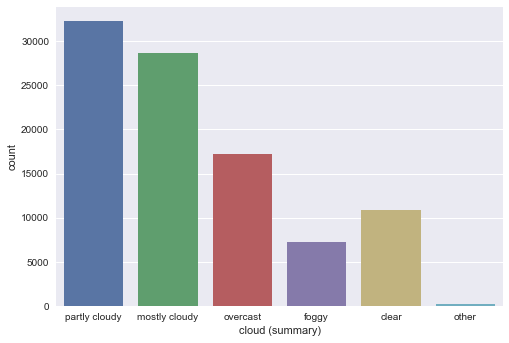

In [118]:
def cloud_category(row,default_category="other"):
    row = str(row).lower()
    if "foggy" in row:
        category = "foggy"
    elif "overcast" in row:
        category = "overcast"
    elif "mostly cloudy" in row:
        category = "mostly cloudy"
    elif "partly cloudy" in row:
        category = "partly cloudy"
    elif "clear" in row:
        category = "clear"
    else:
        category = default_category
    return category

df["cloud (summary)"] = df.apply(lambda row: cloud_category(row["summary"]), axis=1)
sns.countplot(df["cloud (summary)"])

 - Let's explore category "other" to see if it's similar to any other category
 - and compare it with visibility as this correlates to cloudy (summary)

<AxesSubplot:xlabel='cloud (summary)', ylabel='visibility (km)'>

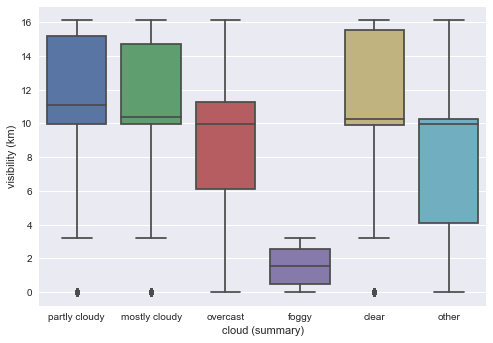

In [119]:
sns.boxplot(x=df["cloud (summary)"], y=df["visibility (km)"])

 - here can see that other & overcast are similar in terms of visibility
 - we can set these in overcast instead of "other"

<AxesSubplot:xlabel='cloud (summary)', ylabel='count'>

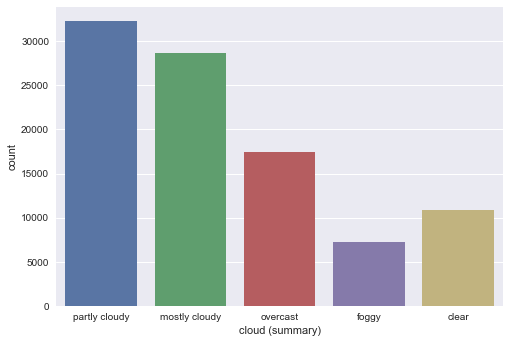

In [120]:
df["cloud (summary)"] = df.apply(lambda row: cloud_category(row["summary"],"overcast"), axis=1)
sns.countplot(df["cloud (summary)"])

## Univariate Analysis

In [121]:
# focus on numerical features
numerical_features = df.select_dtypes(include=["int64","float64"]).keys()
print(numerical_features)
print(len(numerical_features))

Index(['temperature (c)', 'apparent temperature (c)', 'humidity',
       'wind speed (km/h)', 'wind bearing (degrees)', 'visibility (km)',
       'pressure (millibars)'],
      dtype='object')
7


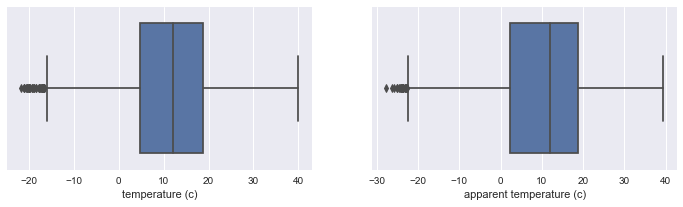

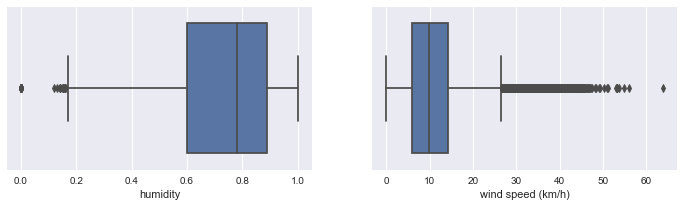

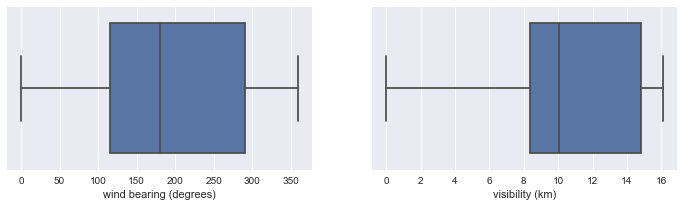

In [122]:
i = 0
while i < 6:
    fig = plt.figure(figsize=[12,3])
    plt.subplot(1,2,1)
    sns.boxplot(x=numerical_features[i], data=df)
    i += 1
    plt.subplot(1,2,2)
    sns.boxplot(x=numerical_features[i], data=df)
    i += 1
    plt.show()
# TO DO: pressure is excluded cause it returns an error with formated subplots above (out of range cause it's paring int) - find a way to solve this

Boxplot notes:
 - *temperature & apparent temperature* has a normal dist. with a couple of outliers the towards lower quartile
 - *humidty* has a left skew and frequency of values lead more towards the max
 - *wind speed* has a right skew & frequencies lean strongly to the min (several outliers on the right)
 - *wind bearing* looks normally distributed here but that's due to it being bimodal
 - *visibility* leans towards the max

## Multivariate Analysis

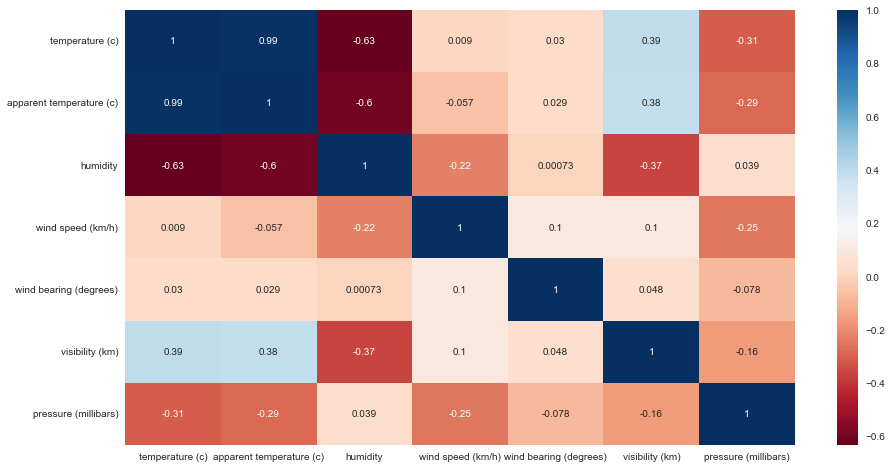

In [123]:
# heatmap correlation
fig = plt.figure(figsize=[15,8])
sns.heatmap(df.corr(), annot=True, cmap='RdBu')
plt.show()

Correlation notes:
 - this indicates that *humidity* has the highest correlation (negative) with temperature
 - then *visibility* correlates to temperature but not so strong

 - Let's look at correlation between temperature & cloud summary

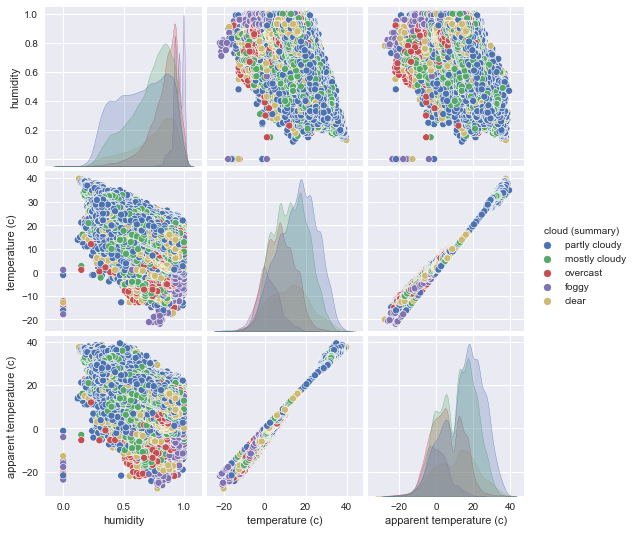

In [124]:
sns.pairplot(df[['humidity','temperature (c)', 'apparent temperature (c)', 'cloud (summary)']], diag_kind='kde', hue='cloud (summary)')

Looking at the pairplot, cloud summary doesn't show correlations for individual types

Let's look now at humidity & temperature alone

In [125]:
df.corr()['temperature (c)'].sort_values(ascending=False)

temperature (c)             1.000000
apparent temperature (c)    0.992629
visibility (km)             0.392847
wind bearing (degrees)      0.029988
wind speed (km/h)           0.008957
pressure (millibars)       -0.308120
humidity                   -0.632255
Name: temperature (c), dtype: float64

#### Relationship between independent & dependent variables

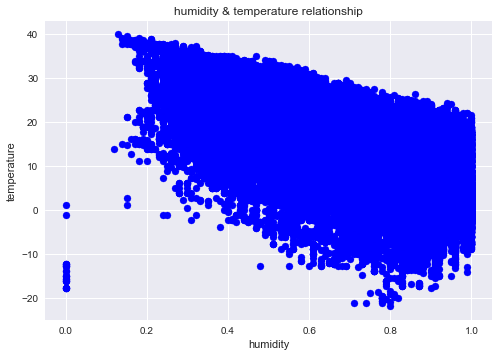

In [141]:
X = np.array(df["humidity"]).reshape(-1,1)
y = np.array(df["temperature (c)"]).reshape(-1,1)

plt.scatter(X, y, color="blue")
plt.title("humidity & temperature relationship")
plt.xlabel('humidity')
plt.ylabel('temperature')
plt.show()

## Train / Test Split

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

print(f"Shape of X_train = {X_train.shape}")
print(f"Shape of X_test = {X_test.shape}")
print(f"Shape of y_train = {y_train.shape}")
print(f"Shape of y_test = {y_test.shape}")

Shape of X_train = (67517, 1)
Shape of X_test = (28936, 1)
Shape of y_train = (67517, 1)
Shape of y_test = (28936, 1)


## Linear Regression with Ordinary Least Squares (from Scratch)

$ y = mx + b $

where:
 - m: slope of the line / intercept
 - x: independent variables
 - b: bias coefficient

#### $ m = \frac{\sum (x_i - \hat{x}) (y_i - \hat{y})} {(x_i - \hat{x})^2}$
#### $ b = \hat{y} - m * \hat{x} $

#### Measure of error & accuracy

#### $ RMSE = \sqrt{\frac{1}{n} \sum (y_i - \hat{y}_j)^2} $
#### $ R^2 = \frac{SSR}{SST} = \frac{\sum(\hat{y_i} - \hat{y})^2}{\sum(y_i - \hat{y})^2}$

In [148]:
"""
Code from scratch

# get means of X & y
X_mean = np.mean(X_train)
y_mean = np.mean(y_train)

# total nr of values
n = len(X)

# formula to calculate slope & intercept
num = 0
den = 0
for i in range(n):
    num += (X_train[i] - X_mean) * (y_train[i] - y_mean)
    den += (X_train[i] - X_mean) ** 2

# m = 0 if den == 0 else num / den
m = num / den
b = y_mean - (m * X_mean)
print(f"Slope = {m}\nIntercept = {b}")
"""

"""
Error & accuracy measures

rmse = 0
for i in range(n):
    y_pred=  b0 + b1* X[i]
    rmse += (Y[i] - y_pred) ** 2
rmse = np.sqrt(rmse/n)

sumofsquares = 0
sumofresiduals = 0
for i in range(n) :
    y_pred = b0 + b1 * X[i]
    sumofsquares += (Y[i] - y_mean) ** 2
    sumofresiduals += (Y[i] - y_pred) **2
score  = 1 - (sumofresiduals/sumofsquares)
"""

'\nCode from scratch\n\n# get means of X & y\nX_mean = np.mean(X)\ny_mean = np.mean(y)\n\n# total nr of values\nn = len(X)\n\n# formula to calculate slope & intercept\nnum = 0\nden = 0\nfor i in range(n):\n    num += (X_train[i] - X_mean) * (y_train[i] - y_mean)\n    den += (X_train[i] - X_mean) ** 2\n\n# m = 0 if den == 0 else num / den\nm = num / den\nb = y_mean - (m * X_mean)\nprint(f"Slope = {m}\nIntercept = {b}")\n'

## Linear Regression with Ordinary Least Squares (with Sklearn)

In [145]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [160]:
prediction = linear_model.predict(X_test)
test_set_rmse = (np.sqrt(mean_squared_error(y_test, prediction)))
test_set_r2 = r2_score(y_test, prediction)
print("RMSE value:",test_set_rmse)
print("R^2 value: ",test_set_r2)

RMSE value: 7.416495118376734
R^2 value:  0.40123280411013007


 - RMSE is low (which is good) - this tells the avg. distance between predicted values from the model & actual values from the data
 - R^2 isn't high which indicates that accuracy is not great (this tells us the proportion of the varianse in the response variable that can be explained by the predictor's variable in the model) - probably due to the noisy data we have

Viz training set results

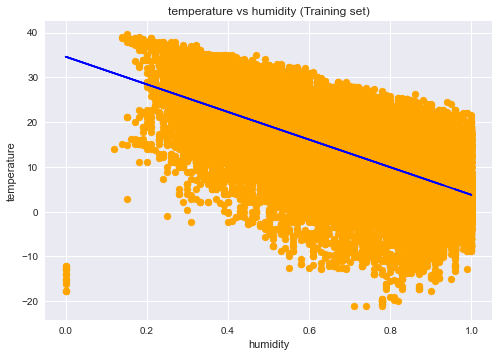

In [149]:
plt.scatter(X_train, y_train, color = 'orange')
plt.plot(X_train, linear_model.predict(X_train), color = 'blue')
plt.title('temperature vs humidity (Training set)')
plt.xlabel('humidity')
plt.ylabel('temperature')
plt.show()

Viz test set results

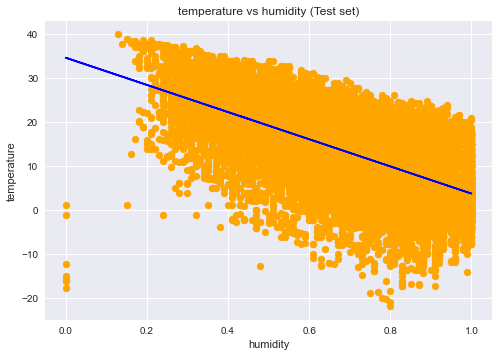

In [150]:
plt.scatter(X_test, y_test, color = 'orange')
plt.plot(X_test, linear_model.predict(X_test), color = 'blue')
plt.title('temperature vs humidity (Test set)')
plt.xlabel('humidity')
plt.ylabel('temperature')
plt.show()

In [158]:
print(f"Coefficient (b) = {linear_model.intercept_}")
print(f"Intercept (m) = {linear_model.coef_}")
print(f"Regression formula: y = {linear_model.coef_} * x + {linear_model.intercept_}")

Coefficient (b) = [34.60057135]
Intercept (m) = [[-30.85581169]]
Regression formula: y = [[-30.85581169]] * x + [34.60057135]


In [156]:
print("Humidity of .6, predicts temperature of:")
linear_model.predict([[.6]])

Humidity of .6, predicts temperature of:


array([[16.08708434]])

Regression with OLS object in stats library

In [161]:
X_train_sm = stats.add_constant(X_train)
lr = stats.OLS(y_train, X_train_sm).fit()

In [162]:
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                 4.484e+04
Date:                Mon, 18 Jul 2022   Prob (F-statistic):               0.00
Time:                        19:50:35   Log-Likelihood:            -2.3087e+05
No. Observations:               67517   AIC:                         4.618e+05
Df Residuals:                   67515   BIC:                         4.618e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.6006      0.111    312.288      0.000      34.383      34.818
x1           -30.8558      0.146   -211.758      0.000     -31.141     -30.570
==============================================================================
Omnibus:                     1629.368   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1749.109
Skew:                          -0.390   Prob(JB):                         0.00
Kurtosis:                       3.117   Cond. No.                         7.96
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### References:
 - [Understanding histograms](https://statisticsbyjim.com/basics/histograms/)
 - [Understanding box & whisker plots](https://flowingdata.com/2008/02/15/how-to-read-and-use-a-box-and-whisker-plot/)